In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import model_selection

## a) load/merge data and visualize logerror

In [2]:
# load data into DataFrames
train = pd.read_csv('train.csv')
prop = pd.read_csv('properties.csv')

In [3]:
print(train.shape, prop.shape)
merged = pd.merge(train, prop, on='id')
print(merged.shape)

(90275, 3) (1048575, 58)
(31725, 60)


In [4]:
# eliminate outliers
logerr = merged.loc[: , "logerror"]

ul = np.percentile(logerr, 99); ll = np.percentile(logerr, 1)
# print(ul,ll)
print(logerr.shape)
logerr[logerr > ul] = ul
logerr[logerr < ll] = ll

(31725,)


C:\Users\rosha\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\rosha\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


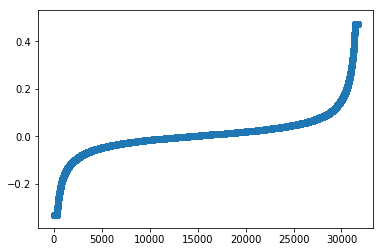

In [24]:
# scatter of logerr
plt.scatter(np.arange(logerr.shape[0]) , np.sort(logerr))
# plt.scatter(merged.loc[:,'id'] , logerr)


(array([ 336.,   20.,   17.,   27.,   26.,   16.,   18.,   23.,   37.,
          31.,   34.,   32.,   31.,   42.,   44.,   42.,   54.,   58.,
          69.,   69.,   88.,   91.,   94.,   99.,  140.,  164.,  174.,
         195.,  244.,  279.,  267.,  413.,  425.,  532.,  725.,  809.,
        1093., 1347., 1685., 2005., 2380., 2443., 2294., 1975., 1779.,
        1333., 1054.,  934.,  711.,  617.,  504.,  437.,  342.,  245.,
         227.,  204.,  194.,  143.,  146.,  122.,  137.,   94.,   98.,
          94.,   75.,   55.,   64.,   63.,   50.,   48.,   48.,   49.,
          42.,   39.,   32.,   36.,   29.,   22.,   34.,   26.,   24.,
          22.,   21.,   18.,   25.,   21.,   19.,   11.,   16.,   10.,
          13.,   15.,    8.,   12.,   10.,   10.,   11.,   14.,    8.,
         323.]),
 array([-3.2990000e-01, -3.2184332e-01, -3.1378664e-01, -3.0572996e-01,
        -2.9767328e-01, -2.8961660e-01, -2.8155992e-01, -2.7350324e-01,
        -2.6544656e-01, -2.5738988e-01, -2.4933320e-01, -2

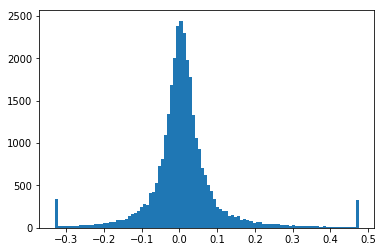

In [6]:
# histogram of logerr
plt.hist(logerr, bins = 100)

## b) data cleaning

In [7]:
# build new data frame
# data_new = merged[['column_name']]

lst2 = merged.isnull().sum()
df_new = pd.DataFrame( list(zip(merged.columns.values, lst2 )), columns =['column_name', 'missing_count'] )

df_new['missing_ratio'] = pd.Series(lst2/len(merged)).values


In [8]:
# fill missing data
merged = merged.fillna(merged.mean())

## c) univariate analysis

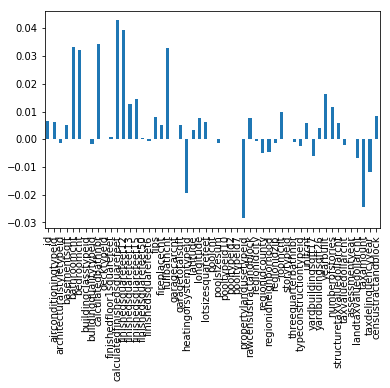

In [9]:
# make bar chart
bar_df = merged.drop(['logerror'], axis=1).corrwith(merged['logerror'])
bar_df.plot.bar()

Explain reason for missing values:

Categorical features fail to provide numerical values when .corrwith() command is used. Thus those feature correlation coefficients are missing.

## d) non-linear regression model

In [11]:
# drop categorical features 
# ("hashottuborspa", "propertycountylandusecode", "propertyzoningdesc", "fireplaceflag", "taxdelinquencyflag") 
# drop "id" and "transactiondate"
merged = merged.drop(['hashottuborspa', "propertycountylandusecode", "propertyzoningdesc", "fireplaceflag", "taxdelinquencyflag", "id", "transactiondate"], axis=1)

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection

In [20]:
# split and train

merge_train, merge_test = sklearn.model_selection.train_test_split(merged, test_size = 0.3)

regr = RandomForestRegressor()
regr.fit( merge_train.drop(['logerror'], axis=1), merge_train['logerror'] )

C:\Users\rosha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

MSE Value =  0.013992068338966728


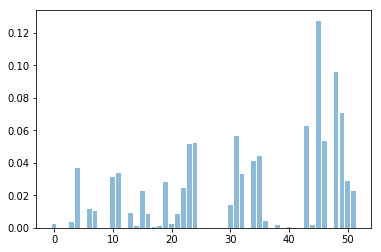

In [19]:
# report importances and mse
importances = regr.feature_importances_
# print(importances)

y_pos = np.arange(len(importances))

plt.bar(y_pos, importances, align='center', alpha=0.5)

pred_labels = regr.predict(merge_test.drop(['logerror'], axis=1))

mse_val = sklearn.metrics.mean_squared_error( merge_test['logerror'].values, pred_labels )
print('MSE Value = ',mse_val)

## e) KFold

In [22]:
# KFold, k = 5
fold_data = merged.loc[0:499]

scores = []
X_fold = fold_data.drop(['logerror'], axis=1)
Y_fold = fold_data['logerror']

kf = model_selection.KFold(n_splits = 5, shuffle = False)

for train_index, test_index in kf.split(X_fold):
    
    X_train, X_test, y_train, y_test = X_fold.iloc[train_index], X_fold.iloc[test_index], Y_fold.iloc[train_index], Y_fold.iloc[test_index]
    regr.fit(X_train, y_train)
    scores.append( sklearn.metrics.mean_squared_error( y_test, regr.predict(X_test) ) )
    
print('Avg MSE = ',np.average(scores))

Avg MSE =  0.014690694788545544


In [16]:
# Run d2 for 100 times
mse_list = []

for i in range(100):

    # split and train
    merge_train, merge_test = sklearn.model_selection.train_test_split(merged.iloc[0:499], test_size = 0.3, random_state = i)
    regr = RandomForestRegressor(n_estimators = 10, random_state = i)
    regr.fit( merge_train.drop(['logerror'], axis=1), merge_train['logerror'] )
    
    pred_labels = regr.predict(merge_test.drop(['logerror'], axis=1))
    
    mse_list.append(sklearn.metrics.mean_squared_error( merge_test['logerror'].values, pred_labels ) )
    

In [23]:
print('Avg MSE = ',np.average(mse_list))

Avg MSE =  0.015381375652345168


Advantage of k-fold: 

k-fold helps the model better get trained on the whole data by shuffling the training and test sets everytime. Thus, the model is better able to learn the entire data irrespective of how the train/test data is split.